# TASK 1 - Complete implementation of vectorized minigrad (6 points)
In the first task it is your goal to finalize the implementation of the provided autograd library. This library is similar to the one we developed during the lesson but it uses numpy to vectorize the calculation.

Once the library is finalized, it will be your task to use it for the following tasks.

In [1]:
import timeit
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from utils import generate_task, visualize_manipulator, to_numpy
from assignments import dkt, dkt_vectorized, manipulator_loss

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# TASK 2.1 - Implement DKT (2 points)
First, you will implement a function that calculates: “Positions of all joints and the end-effector ($X$), given joints angles ($\omega$), link lengths ($\rho$) and base angle and distance from origin ($base$) ”. This function will later help you to find the joint angles needed to move the end effector to desired position. We will use SGD (Stochastic gradient descent) to find desired position of the end-effector.

In general, you can use arbitrary architecture such as a 100-degree polynomial, fully connected neural network, or deep convolutional network and train its parameters to predict positions observed on the real manipulator; however, it is advisable to exploit the knowledge of the underlying kinematic structure. This task is called the Direct Kinematic Task (DKT).

##### For this task implement `dkt()` and `manipulator_loss()` to get 1 points.


Joint angles: [Tensor(data=-0.04736127344735469, grad=0.0, label=omega0), Tensor(data=-0.28851358154801, grad=0.0, label=omega1), Tensor(data=-0.7215424513100375, grad=0.0, label=omega2), Tensor(data=-1.7046137958752456, grad=0.0, label=omega3), Tensor(data=-0.20956930988982037, grad=0.0, label=omega4)]
Link lengths: [Tensor(data=1.0, grad=0.0, label=rho0), Tensor(data=1.0, grad=0.0, label=rho1), Tensor(data=1.0, grad=0.0, label=rho2), Tensor(data=1.0, grad=0.0, label=rho3), Tensor(data=1.0, grad=0.0, label=rho4)]
Base angle and length: [ 0.000  0.000]
Goal coordinates: [ 1.397  6.440]


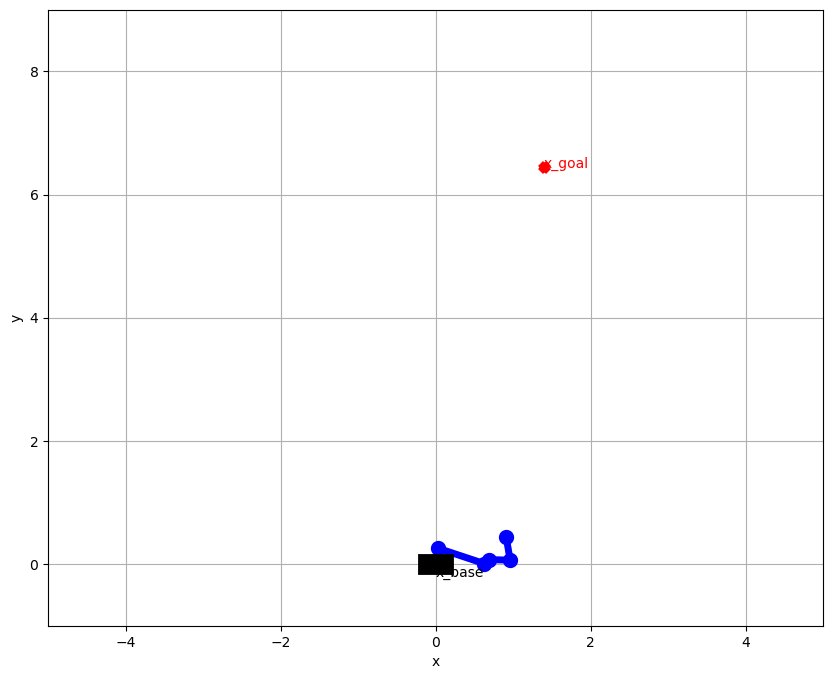

In [2]:
# Generate data for the task
NUMBER_OF_JOINTS = 5
omega, rho, base, x_goal = generate_task(NUMBER_OF_JOINTS)

# Save initial state for repeatability
old_omega, old_rho = omega.copy(), rho.copy()

# Let's take a look at the data
print(f'Joint angles: {omega}')
print(f'Link lengths: {rho}')
print(f'Base angle and length: {base}')
print(f'Goal coordinates: {x_goal}')

# Plot the base with the goal and random manipulator position
X_rand = np.concatenate((np.zeros((2,1)), np.random.rand(2, NUMBER_OF_JOINTS)), axis=1)
visualize_manipulator(X_rand, x_goal)

## Direct Kinematic Task

Our inputs are 3 vectors. First is $\omega$ which represents relative angle of the joints. Second is $\rho$ which represents length of the links. The third is *base* which represents $[\omega_0 \quad \rho_0]$ with respect to origin.
$$
\omega = \begin{bmatrix} \omega_1 \\ \omega_2 \\ \vdots \\ \omega_n \end{bmatrix}, \quad
\rho = \begin{bmatrix} \rho_1 \\ \rho_2 \\ \vdots \\ \rho_n \end{bmatrix}, \quad
base = \begin{bmatrix} \omega_0 \\ \rho_0 \end{bmatrix}
$$

<br/>
<img src="images/dkt.png" width=660 height=336 align="center"/>
<br/>

We can calculate the joint positions using equations

$$
\varphi_k = \omega_0 + \omega_1 + \omega_2 + \ldots + \omega_k \\
x_{k+1} = f_1(x_k,\;\rho_k,\;\varphi_k) \\
y_{k+1} = f_2(y_k,\;\rho_k,\;\varphi_k) \\
$$

After you implement functions $f_1$ and $f_2$ the output is

$$
X = \begin{bmatrix} x_0 & x_1 & \ldots & x_n \\ y_0 & y_1 & \ldots & y_n \end{bmatrix}
$$

In [3]:
# Change matplotlib backend for animation
matplotlib.use('Qt5Agg')

# Parameters (PLAY WITH THEM!!!)
# ------------- PLAY TIME -------------
learning_rate = 0.003
n_iterations = 200
# -------------------------------------

for i in range(n_iterations):

    # Compute positions of the joints
    #----------------------------------------------------------
    # TODO: implement dkt function
    #----------------------------------------------------------
    X = dkt(omega, rho, base)    

    # Compute loss
    #----------------------------------------------------------
    # TODO: implement manipulator_loss function
    loss = manipulator_loss(X, x_goal)
    #----------------------------------------------------------

    # Compute gradient
    loss.backward()

    # Make an optimization step and reset the gradient
    loss.step(learning_rate)
    loss.zero_grad()

    print(f'Iteration: {i}, loss = {loss.data.flatten()}, rho (link lengths) = {to_numpy(rho).flatten()}')
    if i % 5 == 0:
        X = to_numpy(X)
        X[0].flatten(), X[1].flatten()
        visualize_manipulator(X, x_goal)

# Reset omega and rho for repeatability
omega, rho = old_omega.copy(), old_rho.copy()

# Change matplotlib backend back to inline
%matplotlib inline

Iteration: 0, loss = [ 68.457], rho (link lengths) = [ 1.002  0.992  0.973  0.985  0.991]
Iteration: 1, loss = [ 64.371], rho (link lengths) = [ 1.005  0.986  0.947  0.972  0.986]
Iteration: 2, loss = [ 60.437], rho (link lengths) = [ 1.009  0.980  0.921  0.962  0.984]
Iteration: 3, loss = [ 56.661], rho (link lengths) = [ 1.013  0.975  0.895  0.955  0.986]
Iteration: 4, loss = [ 53.060], rho (link lengths) = [ 1.018  0.970  0.869  0.951  0.992]
Iteration: 5, loss = [ 49.654], rho (link lengths) = [ 1.023  0.965  0.844  0.950  1.001]
Iteration: 6, loss = [ 46.468], rho (link lengths) = [ 1.029  0.961  0.819  0.951  1.012]
Iteration: 7, loss = [ 43.519], rho (link lengths) = [ 1.034  0.957  0.795  0.955  1.026]
Iteration: 8, loss = [ 40.819], rho (link lengths) = [ 1.040  0.952  0.771  0.961  1.042]
Iteration: 9, loss = [ 38.368], rho (link lengths) = [ 1.046  0.948  0.747  0.969  1.060]
Iteration: 10, loss = [ 36.156], rho (link lengths) = [ 1.051  0.943  0.724  0.979  1.079]
Iteration

# TASK 2.2 - Implement vectorized DKT (2 point)

Now you will implement fully vectorized DKT with no `for` loop. Why? Because vectorized operations in numpy and pytorch are a lot faster than normal iterations. Don't you believe? Try it yourself! :D

##### For this task implement `dkt_vectorized()` to get 1 point.

## DKT Vectorized

Our inputs are three vectors. First is $\omega$ which represents relative angles of the joints. Second is $\rho$ which represents lengths of the links. Third is $base$ which represents base angle and distance from origin ([0, 0]). Let's take an example when we have 3 joints.
$$
\omega = \begin{bmatrix} \omega_1 \\ \omega_2 \end{bmatrix}, \quad
\rho = \begin{bmatrix} \rho_1 \\ \rho_2 \end{bmatrix}, \quad
base = \begin{bmatrix} \omega_0 \\ \rho_0 \end{bmatrix}
$$

First we can calculate total angle of each joint by equation $\varphi_k = \omega_1 + \omega_2 + \ldots + \omega_k$. In our 3 joint case we can write the equation as follows.
$$
\begin{bmatrix} 1 & 0 & 0 \\ 1 & 1 & 0 \\ 1 & 1 & 1 \end{bmatrix}
\cdot
\begin{bmatrix} \omega_0 \\ \omega_1 \\ \omega_2 \end{bmatrix}
=
\begin{bmatrix} \omega_0 \\ \omega_0 + \omega_1 \\ \omega_0 + \omega_1 + \omega_2 \end{bmatrix}
=
\begin{bmatrix} \varphi_0 \\ \varphi_1 \\ \varphi_2 \end{bmatrix}\\
$$

Then we calculate the position of joints with respect to origin $[0 \quad 0]$.

$$
\begin{bmatrix}
    \cos{\varphi_0} & \cos{\varphi_1} & \cos{\varphi_2} \\
    \sin{\varphi_0} & \sin{\varphi_1} & \sin{\varphi_2}
\end{bmatrix}
\cdot
\begin{bmatrix}
    \rho_0 & 0 & 0 \\ 0 & \rho_1 & 0 \\ 0 & 0 & \rho_2
\end{bmatrix}
= \\
\begin{bmatrix}
    \rho_0 \cdot \cos{\varphi_0} & \rho_1 \cdot \cos{\varphi_1} & \rho_2 \cdot \cos{\varphi_2} \\
    \rho_0 \cdot \sin{\varphi_0} & \rho_1 \cdot \sin{\varphi_1} & \rho_2 \cdot \sin{\varphi_2}
\end{bmatrix}
=
\begin{bmatrix} x_0' & x_1' & x_3' \\ y_0' & y_1' & y_3' \end{bmatrix}
$$

And finally we can calculate the real position of the joints.

$$
\begin{bmatrix} x_0' & x_1' & x_3' \\ y_0' & y_1' & y_3' \end{bmatrix}
\cdot
\begin{bmatrix} 1 & 1 & 1 \\ 0 & 1 & 1 \\ 0 & 0 & 1 \end{bmatrix}
=
\begin{bmatrix} x_0 & x_1 & x_3 \\ y_0 & y_1 & y_3 \end{bmatrix}
= X
$$

## Important notice
All necessary functions are implemented in the engine library. You may implement more but the ones that are already there should be sufficient.

It is also important to understand that all operation should be done on the Tensor object or objects. Therefore it is necessary to transform all intermediary numpy arrays to Tensor object before starting calculations with them.

In [4]:
# Generate data for the task
NUMBER_OF_JOINTS = 100
omega, rho, base, x_goal = generate_task(NUMBER_OF_JOINTS)

# Compute the positions
X_1 = dkt(omega, rho, base)
#----------------------------------------------------------
# TODO: implement dkt function
X_2 = dkt_vectorized(omega, rho, base)
#----------------------------------------------------------

# Compare the results
if np.sum(np.abs(to_numpy(X_2).flatten() - to_numpy(X_1).flatten())) < 1e-1:
    print("\nNicely done! Your vectorized and non-vectorized function matches.")

    print("\nTesting execution time of non-vectorized dkt...")
    %timeit dkt(omega, rho, base)

    print("\nTesting execution time of vectorized dkt...")
    %timeit dkt_vectorized(omega, rho, base)
else:
    print("Try harder!")


Nicely done! Your vectorized and non-vectorized function matches.

Testing execution time of non-vectorized dkt...


: 